# diagnostics of iHesp climatology

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pop_tools 
from geocat.viz import util as gvutil
import datetime
import cf_units as cf
import cmocean
import dask

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client


In [3]:
# method: 0 for difference 1 for mean
# note that xarray.copy, if you are copying the variable's data to the new data, the origial array will be affected
# i.e.. b=a.copy(data=a.data), then b=a[2]-a[1], will change a[2] value

def get_anoms(variable, index, istart, iend, bdays,adays, method, climo=None):
    ncases = iend - istart
    anoms = variable[istart:iend+1, :,:].copy(data=np.array(variable[istart:iend+1,:,:].data))
    anoms.data = np.zeros(anoms.shape)
    j = 0
    print(j)
    for i in np.arange(istart, iend):
        hit_day = index[i]
        before = index[i] - pd.to_timedelta(bdays,'D')     # 3 days before and maximum 7 days after
        after = index[i] + pd.to_timedelta(adays,'D')
      
        if (variable.time.dt.date.isin(before.dt.date).any()) & (variable.time.dt.date.isin(after.dt.date).any()):
            if method == 0:
                anoms[j,:,:] = np.array(variable.sel(time=after) - variable.sel(time=before))
            if method == 1:
                ar_range = variable.sel(time=slice(before,after))
                anoms[j,:,:] = ar_range.mean('time') - climo.sel(month=before.dt.month)
            anoms[j,:,:] = anoms[j].where(np.isfinite(anoms[j]),-99999)
            anoms[j,:,:]['time'] = index[i]
#        print(index[i])
            j = j + 1                                 
    anoms = anoms.assign_attrs({'units':variable.units})
    return anoms

In [4]:
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='20GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project='P93300313', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status'})

# Setup your client
client = Client(cluster)


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41180 instead
  expected, actual


In [5]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.56:37549,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## 1. read in data 1950-1969

## 1.1 Get regrided surface heat flux

In [7]:
import glob as _glob
import os as _os

ocn_dir = "/glade/scratch/huili7/AR_cases/data/"
ocn_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SHF.19[56]*"
shf_files = sorted(_glob.glob(ocn_path))

In [8]:
var='SHF'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [9]:
dsh0 = xr.open_mfdataset(shf_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [10]:
shf0 = dsh0.SHF
shf_new = shf0.roll(lon=180)             #lonflip 
shf_new['lon'] = np.arange(-180,180,1)
del(shf0)
shf_1950 = shf_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(shf_new)

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [12]:
shf_1950['time'] = shf_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [14]:
ocn_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SHF.20[34]*"
shf_files = sorted(_glob.glob(ocn_path))

In [15]:
dsh1 = xr.open_mfdataset(shf_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [16]:
shf1 = dsh1.SHF
shf_new = shf1.roll(lon=180)             #lonflip 
shf_new['lon'] = np.arange(-180,180,1)
del(shf1)
shf_2050 = shf_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(shf_new)
shf_2050['time'] = shf_2050.indexes['time'].to_datetimeindex()

### 1.2 get regridded daily SSH

<h1 style="red' now find timing AR \>
### 1. 
           from AR case  -- ar_date

The original date from the netcdf files are just integers. We will need to convert them to datetime class for easy manipulation and indexing

We use the datetim.datetime()

In [19]:
ssh_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SSH.19[56]*"
ssh_files = sorted(_glob.glob(ssh_path))

In [20]:
var='SSH'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [21]:
dshh0 = xr.open_mfdataset(ssh_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [23]:
ssh0 = dshh0.SSH
ssh_new = ssh0.roll(lon=180)             #lonflip 
ssh_new['lon'] = np.arange(-180,180,1)
#del(ssh0)
ssh_1950 = ssh_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(ssh_new)
ssh_1950['time'] = ssh_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [26]:
ssh_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-2015-2050.013.pop.h.nday1.SSH.20[34]*"
ssh_files = sorted(_glob.glob(ssh_path))

In [27]:
dshh = xr.open_mfdataset(ssh_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [28]:
ssh0 = dshh.SSH
ssh_new = ssh0.roll(lon=180)             #lonflip 
ssh_new['lon'] = np.arange(-180,180,1)
del(ssh0)
ssh_2050 = ssh_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(ssh_new)

In [29]:
ssh_2050['time'] = ssh_2050.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


## 1.3 get SST

In [31]:
sst_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SST.19[56]*"
sst_files = sorted(_glob.glob(sst_path))

In [32]:
var='SST'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [33]:
dsst0 = xr.open_mfdataset(sst_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [34]:
sst0 = dsst0.SST
sst_new = sst0.roll(lon=180)             #lonflip 
sst_new['lon'] = np.arange(-180,180,1)
#del(sst0)
sst_1950 = sst_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(sst_new)
sst_1950['time'] = sst_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [35]:
sst_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SST.20[34]*"
sst_files = sorted(_glob.glob(sst_path))

In [36]:
dsst = xr.open_mfdataset(sst_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [37]:
sst0 = dsst.SST
sst_new = sst0.roll(lon=180)             #lonflip 
sst_new['lon'] = np.arange(-180,180,1)
#del(sst0)
sst_2050 = sst_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(sst_new)
sst_2050['time'] = sst_2050.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


## 1.4 read in evaporation

In [38]:
evap_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.EVAP_F.19[56]*"
evap_files = sorted(_glob.glob(evap_path))

In [39]:
var='EVAP_F'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [40]:
dsev0 = xr.open_mfdataset(evap_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [41]:
evap0 = dsev0.EVAP_F
evap_new = evap0.roll(lon=180)             #lonflip e
evap_new['lon'] = np.arange(-180,180,1)
del(evap0)
evap_1950 = evap_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(evap_new)
evap_1950['time'] = evap_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [43]:
evap_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.EVAP_F.20[34]*"
evap_files = sorted(_glob.glob(evap_path))

In [44]:
dsev = xr.open_mfdataset(evap_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [45]:
evap0 = dsev.EVAP_F
evap_new = evap0.roll(lon=180)             #lonflip e
evap_new['lon'] = np.arange(-180,180,1)
del(evap0)
evap_2050 = evap_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(evap_new)
evap_2050['time'] = evap_2050.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


## 1.5 get sensible heat

In [46]:
sen_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SENH_F.19[56]*"
sen_files = sorted(_glob.glob(sen_path))

In [47]:
var='SENH_F'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [48]:
dsen0 = xr.open_mfdataset(sen_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [49]:
sen0 = dsen0.SENH_F
sen_new = sen0.roll(lon=180)             #lonflip 
sen_new['lon'] = np.arange(-180,180,1)
#del(ssh0)
sen_1950 = sen_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(sen_new)
sen_1950['time'] = sen_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [50]:
sen_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SENH_F.20[34]*"
sen_files = sorted(_glob.glob(sen_path))

In [51]:
dsen = xr.open_mfdataset(sen_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [52]:
sen0 = dsen.SENH_F
sen_new = sen0.roll(lon=180)             #lonflip 
sen_new['lon'] = np.arange(-180,180,1)
del(sen0)
sen_2050 = sen_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(sen_new)
sen_2050['time'] = sen_2050.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


## 1.7.get HMXL

In [54]:
h_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.HMXL.19[56]*"
h_files = sorted(_glob.glob(h_path))

In [55]:
var='HMXL'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [56]:
dshm0 = xr.open_mfdataset(h_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [57]:
h0 = dshm0.HMXL
h0_new = h0.roll(lon=180)             #lonflip 
h0_new['lon'] = np.arange(-180,180,1)
del(h0)
hmxl_1950 = h0_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(h0_new)
hmxl_1950['time'] = hmxl_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [58]:
h_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.HMXL.20[34]*"
h_files = sorted(_glob.glob(h_path))

In [59]:
dshm = xr.open_mfdataset(h_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [60]:
h0 = dshm.HMXL
h0_new = h0.roll(lon=180)             #lonflip 
h0_new['lon'] = np.arange(-180,180,1)
del(h0)
hmxl_2050 = h0_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(h0_new)
hmxl_2050['time'] = hmxl_2050.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


## 1.7 get taux, tauy

In [61]:
t_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.19[56]*"
t_files = sorted(_glob.glob(t_path))


In [62]:
var='TAUX'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [63]:
dtau0 = xr.open_mfdataset(t_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [64]:
taux0 = dtau0.TAUX
taux_new = taux0.roll(lon=180)             #lonflip 
taux_new['lon'] = np.arange(-180,180,1)
del(taux0)
taux_1950 = taux_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(taux_new)
taux_1950['time'] = taux_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [65]:
t_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-2015-2050.013.pop.h.nday1.TAUX.20[34]*"
t_files = sorted(_glob.glob(t_path))


In [66]:
dtau = xr.open_mfdataset(t_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [67]:
taux0 = dtau.TAUX
taux_new = taux0.roll(lon=180)             #lonflip 
taux_new['lon'] = np.arange(-180,180,1)
del(taux0)
taux_2050 = taux_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(taux_new)
taux_2050['time'] = taux_2050.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


#### now tauy

In [68]:
ty_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUY.19[56]*"
ty_files = sorted(_glob.glob(ty_path))


In [69]:
var='TAUY'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [70]:
dtauy0 = xr.open_mfdataset(ty_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [71]:
tauy0 = dtauy0.TAUY
tauy_new = tauy0.roll(lon=180)             #lonflip 
tauy_new['lon'] = np.arange(-180,180,1)
del(tauy0)
tauy_1950 = tauy_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(tauy_new)
tauy_1950['time'] = tauy_1950.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [72]:
ty_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-2015-2050.013.pop.h.nday1.TAUY.20[34]*"
ty_files = sorted(_glob.glob(ty_path))


In [73]:
dtauy = xr.open_mfdataset(ty_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [74]:
tauy0 = dtauy.TAUY
tauy_new = tauy0.roll(lon=180)             #lonflip 
tauy_new['lon'] = np.arange(-180,180,1)
del(tauy0)
tauy_2050 = tauy_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(tauy_new)
tauy_2050['time'] = tauy_2050.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


## 2 get climatology

### 2.1 for 1950

In [106]:
sst_climo = sst_1950.groupby(sst_1950.time.dt.month).mean(keep_attrs=True)
hmxl_climo = hmxl_1950.groupby(hmxl_1950.time.dt.month).mean(keep_attrs=True)
taux_climo = taux_1950.groupby(taux_1950.time.dt.month).mean(keep_attrs=True)
tauy_climo = tauy_1950.groupby(tauy_1950.time.dt.month).mean(keep_attrs=True)
ssh_climo = ssh_1950.groupby(ssh_1950.time.dt.month).mean(keep_attrs=True)
evap_climo = evap_1950.groupby(evap_1950.time.dt.month).mean(keep_attrs=True)
sen_climo = sen_1950.groupby(sen_1950.time.dt.month).mean(keep_attrs=True)
shf_climo = shf_1950.groupby(shf_1950.time.dt.month).mean(keep_attrs=True)

### 2.2 for 2050

In [94]:
sst_climo2 = sst_2050.groupby(sst_2050.time.dt.month).mean(keep_attrs=True)
hmxl_climo2 = hmxl_2050.groupby(hmxl_2050.time.dt.month).mean(keep_attrs=True)
taux_climo2 = taux_2050.groupby(taux_2050.time.dt.month).mean(keep_attrs=True)
tauy_climo2 = tauy_2050.groupby(tauy_2050.time.dt.month).mean(keep_attrs=True)
ssh_climo2 = ssh_2050.groupby(ssh_2050.time.dt.month).mean(keep_attrs=True)
evap_climo2 = evap_2050.groupby(evap_2050.time.dt.month).mean(keep_attrs=True)
sen_climo2 = sen_2050.groupby(sen_2050.time.dt.month).mean(keep_attrs=True)
shf_climo2 = shf_2050.groupby(shf_2050.time.dt.month).mean(keep_attrs=True)

### 2.3 get differences

In [108]:
sst_diff = sst_climo.copy(data=sst_climo2.data - sst_climo.data)
hmxl_diff = hmxl_climo.copy(data=hmxl_climo2.data - hmxl_climo.data)
taux_diff = taux_climo.copy(data=taux_climo2.data - taux_climo.data)
tauy_diff =tauy_climo.copy(data=tauy_climo2.data - tauy_climo.data)
ssh_diff = ssh_climo.copy(data=ssh_climo2.data - ssh_climo.data)
evap_diff = evap_climo.copy(data=evap_climo2.data - evap_climo.data)
sen_diff = sen_climo.copy(data=sen_climo2.data - sen_climo.data)
shf_diff = shf_climo.copy(data=shf_climo2.data - shf_climo.data)

In [114]:
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [115]:
## define plotting funcition
def var_plot_panels(variable, x, y,u, v, scale, nrows, ncols, i, levels, colormap, title):
    ax1= fig.add_subplot(nrows, ncols, i, projection=ccrs.PlateCarree(central_longitude=0))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)

    plt.colorbar(contour,
                     ax=ax1,
#                     ticks=ticks,
                     orientation='horizontal',
                     pad=0.1,
                     drawedges=True,
                     shrink=0.9,
                     label=variable.units)
    
    csq = ax1.quiver(x, y, u, v,scale=scale)


    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=15)
    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-160, -110),
                                 ylim=(15, 55),
                                 xticks=np.linspace(-160, -110, 3),
                                 yticks=np.linspace(15, 55, 5))

    gvutil.add_major_minor_ticks(ax1, labelsize=12)
    gvutil.add_lat_lon_ticklabels(ax1)


In [140]:
evap_diff_e5 = evap_diff * 1e5
evap_diff_e5 = evap_diff_e5.assign_attrs({'units':evap_diff.units})

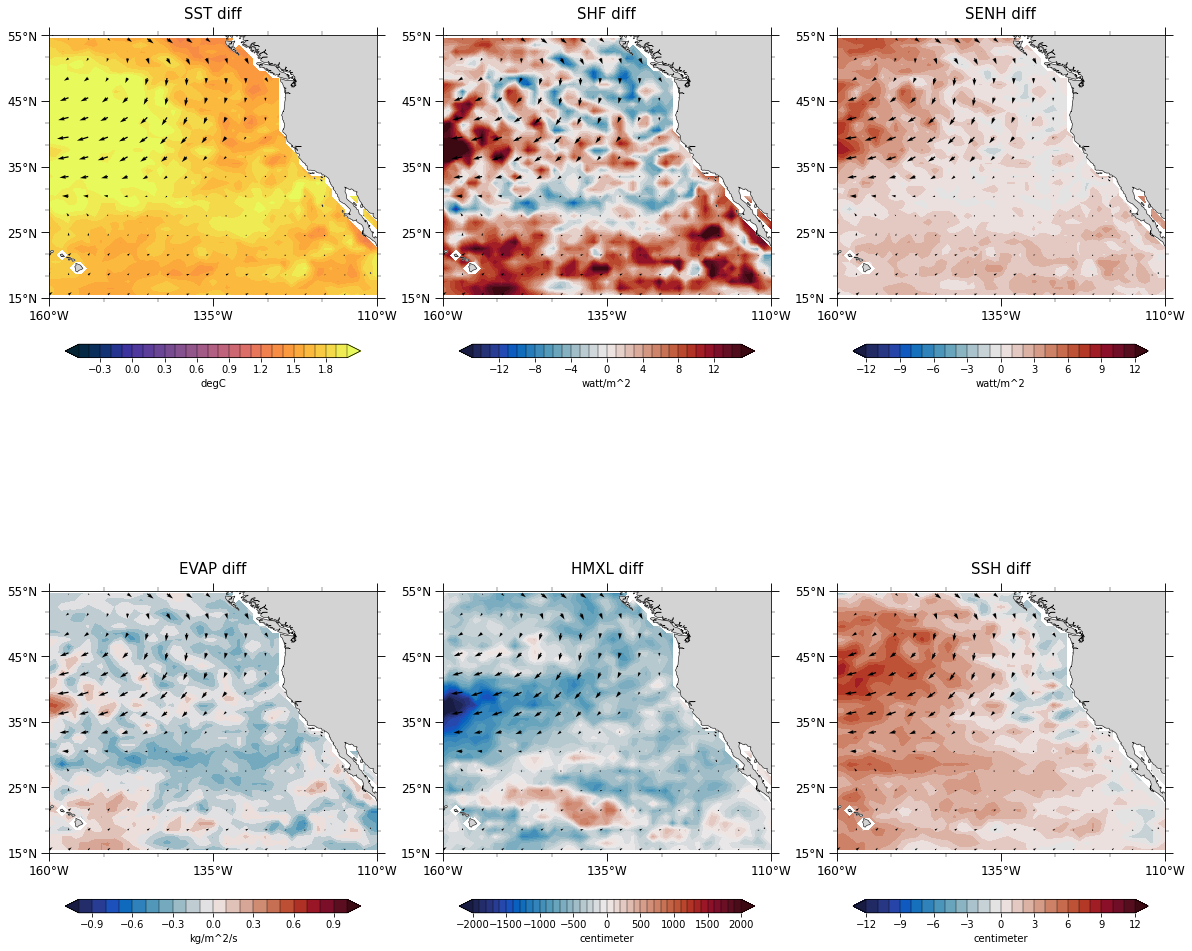

In [147]:
fig=plt.figure(figsize=(20,80))

veclon = taux_climo.lon[::3]
veclat = taux_climo.lat[::3]

taux_space = taux_diff[:,::3,::3].mean('month')
tauy_space = tauy_diff[:,::3,::3].mean('month')

levels=np.arange(-0.5, 2.1, 0.1)
var_plot_panels(sst_diff.sel(month=[1,2,11,12]).mean('month',keep_attrs=True), veclon, veclat, taux_space, tauy_space,5, 8, 3, 1, levels, cmocean.cm.thermal,"SST diff")
var_plot_panels(shf_diff.sel(month=[1,2,11,12]).mean('month',keep_attrs=True), veclon, veclat, taux_space, tauy_space,5, 8, 3, 2, np.arange(-15, 16, 1), cmocean.cm.balance,"SHF diff")
var_plot_panels(sen_diff.sel(month=[1,2,11,12]).mean('month',keep_attrs=True), veclon, veclat, taux_space, tauy_space,5, 8, 3, 3, np.arange(-12, 13, 1), cmocean.cm.balance,"SENH diff")
var_plot_panels(evap_diff_e5.sel(month=[1,2,11,12]).mean('month',keep_attrs=True), veclon, veclat, taux_space, tauy_space,5, 8, 3, 4, np.arange(-1, 1.1, 0.1), cmocean.cm.balance,"EVAP diff")
var_plot_panels(hmxl_diff.sel(month=[1,2,11,12]).mean('month',keep_attrs=True), veclon, veclat, taux_space, tauy_space,5, 8, 3, 5, np.arange(-2000, 2100, 100), cmocean.cm.balance,"HMXL diff")
var_plot_panels(ssh_diff.sel(month=[1,2,11,12]).mean('month',keep_attrs=True), veclon, veclat, taux_space, tauy_space,5, 8, 3, 6, np.arange(-12, 13, 1), cmocean.cm.balance,"SSH diff")





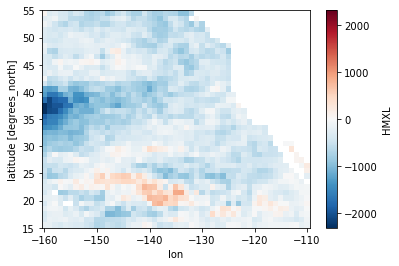

In [146]:
hmxl_diff.sel(month=[1,2,11,12]).mean('month').plot()